**Credit Risk Prediction model**
Goal: To build a machine learning model using XGBoost that predicts the liklihood of a person defaulting on a loan (1 = Default, 0 = No Default).

Dataset is from kaggle and the link to dataset is attached below.
https://www.kaggle.com/datasets/laotse/credit-risk-dataset/code



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd


In [ ]:
file_path = '/content/drive/MyDrive/credit_risk/credit_risk_dataset.csv'
df = pd.read_csv(file_path)
#print(df.columns)

**1. Exploratory Data Analysis (EDA)**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [ ]:
df.isnull().sum()

,0
person_age,0
person_income,0
person_home_ownership,0
person_emp_length,895
loan_intent,0
loan_grade,0
loan_amnt,0
loan_int_rate,3116
loan_status,0
loan_percent_income,0


In [ ]:
df.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,31686.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.142630,6322.086646,3.240459,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


In [ ]:
print(f'Original shape: {df.shape}')
print(df[['person_age', 'person_emp_length']].describe())

Original shape: (32581, 12)
         person_age  person_emp_length
count  32581.000000       31686.000000
mean      27.734600           4.789686
std        6.348078           4.142630
min       20.000000           0.000000
25%       23.000000           2.000000
50%       26.000000           4.000000
75%       30.000000           7.000000
max      144.000000         123.000000


In [ ]:
df_cleaned = df[df['person_age'] <=100]
df_cleaned = df_cleaned[(df_cleaned['person_emp_length'] <=100) | (df_cleaned['person_emp_length'].isnull())]

In [ ]:
print(f"Shape after removing outliers: {df_cleaned.shape}")
print(df_cleaned[['person_age', 'person_emp_length']].describe())

Shape after removing outliers: (32574, 12)
         person_age  person_emp_length
count  32574.000000       31679.000000
mean      27.718426           4.782064
std        6.204987           4.034948
min       20.000000           0.000000
25%       23.000000           2.000000
50%       26.000000           4.000000
75%       30.000000           7.000000
max       94.000000          41.000000


In [ ]:
median_emp_length = df_cleaned['person_emp_length'].median()
print(f"Median emp_length: {median_emp_length}")
df_cleaned['person_emp_length'] = df_cleaned['person_emp_length'].fillna(median_emp_length)


Median emp_length: 4.0


In [ ]:
# Step 4a: Calculate the median interest rate for each loan grade
median_rates_by_grade = df_cleaned.groupby('loan_grade')['loan_int_rate'].median()

print("Median rates by grade:")
print(median_rates_by_grade)

# Step 4b: Use .transform() to create a series of median rates matching the df_cleaned index
# This is a bit advanced but very powerful. It lines up the correct median rate for every row's loan grade.
impute_values = df_cleaned['loan_grade'].map(median_rates_by_grade)

# Step 4c: Fill the missing 'loan_int_rate' values with the corresponding median rate for its grade
df_cleaned['loan_int_rate'] = df_cleaned['loan_int_rate'].fillna(impute_values)

Median rates by grade:
loan_grade
A     7.490
B    10.990
C    13.480
D    15.310
E    16.820
F    18.535
G    20.160
Name: loan_int_rate, dtype: float64


In [ ]:
# Checking remaining missing values
print("\n--- Final Data Check ---")
df_cleaned.info()


--- Final Data Check ---
<class 'pandas.core.frame.DataFrame'>
Index: 32574 entries, 1 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32574 non-null  int64  
 1   person_income               32574 non-null  int64  
 2   person_home_ownership       32574 non-null  object 
 3   person_emp_length           32574 non-null  float64
 4   loan_intent                 32574 non-null  object 
 5   loan_grade                  32574 non-null  object 
 6   loan_amnt                   32574 non-null  int64  
 7   loan_int_rate               32574 non-null  float64
 8   loan_status                 32574 non-null  int64  
 9   loan_percent_income         32574 non-null  float64
 10  cb_person_default_on_file   32574 non-null  object 
 11  cb_person_cred_hist_length  32574 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.2+ MB


In [ ]:
cleaned_file_path = '/content/drive/MyDrive/credit_risk/credit_risk_cleanedd.csv'

df_cleaned.to_csv(cleaned_file_path, index=False)
print(f'Saved successfully : {cleaned_file_path}')

Saved successfully : /content/drive/MyDrive/credit_risk/credit_risk_cleanedd.csv


**2. Feature Engineering and preprocessing**

In [6]:
cleaned_file_path = '/content/drive/MyDrive/credit_risk/credit_risk_cleanedd.csv'
df_cleaned = pd.read_csv(cleaned_file_path)
#print(df.columns)


In [7]:
# Creating new feature
df_cleaned['loan_to_income_ratio'] = df_cleaned['loan_amnt'] / df_cleaned['person_income']

print("\n--- New Feature Created ---")
print(df_cleaned[['person_income', 'loan_amnt', 'loan_to_income_ratio']].head())


--- New Feature Created ---
   person_income  loan_amnt  loan_to_income_ratio
0           9600       1000              0.104167
1           9600       5500              0.572917
2          65500      35000              0.534351
3          54400      35000              0.643382
4           9900       2500              0.252525


In [8]:
# Create a list of the categorical columns we need to encode
categorical_columns = [
    'person_home_ownership',
    'loan_intent',
    'loan_grade',
    'cb_person_default_on_file'
]

df_processed = pd.get_dummies(df_cleaned, columns=categorical_columns, drop_first=True)

# --- Check our final, fully-processed DataFrame ---
print("\n--- Data After One-Hot Encoding ---")
print(f"Original columns: {df_cleaned.shape[1]}")
print(f"New columns: {df_processed.shape[1]}")

print("\n--- Final Data Types ---")
df_processed.info()


--- Data After One-Hot Encoding ---
Original columns: 13
New columns: 24

--- Final Data Types ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32574 entries, 0 to 32573
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   person_age                   32574 non-null  int64  
 1   person_income                32574 non-null  int64  
 2   person_emp_length            32574 non-null  float64
 3   loan_amnt                    32574 non-null  int64  
 4   loan_int_rate                32574 non-null  float64
 5   loan_status                  32574 non-null  int64  
 6   loan_percent_income          32574 non-null  float64
 7   cb_person_cred_hist_length   32574 non-null  int64  
 8   loan_to_income_ratio         32574 non-null  float64
 9   person_home_ownership_OTHER  32574 non-null  bool   
 10  person_home_ownership_OWN    32574 non-null  bool   
 11  person_home_ownership_RENT   325

**3. Data Balancing and Model Training**

In [9]:
# For splitting data
from sklearn.model_selection import train_test_split

# For fixing the imbalance
from imblearn.over_sampling import SMOTE

# The model itself
from xgboost import XGBClassifier

In [10]:
# Our target variable
y = df_processed['loan_status']

# Our features (all columns EXCEPT the target)
X = df_processed.drop('loan_status', axis=1)

# Let's check the shapes to confirm
print(f"Shape of X (features): {X.shape}")
print(f"Shape of y (target):   {y.shape}")

Shape of X (features): (32574, 23)
Shape of y (target):   (32574,)


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# We 'stratify=y' to make sure our train and test sets
# have the same percentage of defaulters (1s) as the original data.

# Check the target variable in our new training set
# You'll see it's still imbalanced (many more 0s than 1s)
print("\n--- Original Training Data (Imbalanced) ---")
print(y_train.value_counts())


--- Original Training Data (Imbalanced) ---
loan_status
0    20373
1     5686
Name: count, dtype: int64


In [12]:
print("\n--- Applying SMOTE to Training Data ---")

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Now, check the counts. They should be perfectly balanced.
print("\n--- New Resampled Training Data (Balanced) ---")
print(y_train_resampled.value_counts())


--- Applying SMOTE to Training Data ---

--- New Resampled Training Data (Balanced) ---
loan_status
0    20373
1    20373
Name: count, dtype: int64


In [13]:
print("\n--- Training the XGBoost Model ---")

# Initialize the model
# We use 'random_state=42' for reproducible results
model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Train the model on our resampled data
model.fit(X_train_resampled, y_train_resampled)

print("--- Model Training Complete! ---")


--- Training the XGBoost Model ---


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [06:00:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


--- Model Training Complete! ---


**4. Model Evaluation and Interpretation**

In [14]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    precision_recall_curve,
    auc
)
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
# Make predictions
y_pred = model.predict(X_test)

# Get prediction probabilities (needed for AUC-ROC)
y_pred_proba = model.predict_proba(X_test)[:, 1]

In [16]:
print("--- Classification Report ---")
print(classification_report(y_test, y_pred, target_names=['Will Not Default (0)', 'Will Default (1)']))

--- Classification Report ---
                      precision    recall  f1-score   support

Will Not Default (0)       0.93      0.99      0.96      5094
    Will Default (1)       0.94      0.73      0.82      1421

            accuracy                           0.93      6515
           macro avg       0.94      0.86      0.89      6515
        weighted avg       0.93      0.93      0.93      6515




--- Confusion Matrix ---


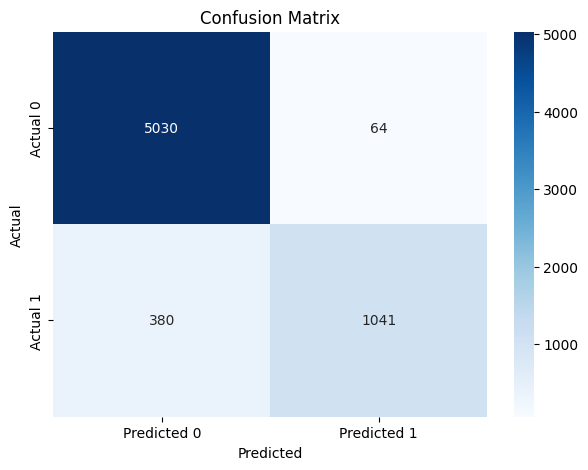

In [17]:
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred)

# Plotting it to make it easier to read
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [18]:
# Calculate the AUC-ROC Score
auc_roc = roc_auc_score(y_test, y_pred_proba)
print(f"\n--- AUC-ROC Score ---")
print(f"The AUC-ROC Score is: {auc_roc:.4f}")


--- AUC-ROC Score ---
The AUC-ROC Score is: 0.9454



--- Top 10 Most Important Features ---
                        Feature  Importance
18                 loan_grade_D    0.252274
10   person_home_ownership_RENT    0.144369
19                 loan_grade_E    0.095601
7          loan_to_income_ratio    0.053539
20                 loan_grade_F    0.052461
17                 loan_grade_C    0.046122
12  loan_intent_HOMEIMPROVEMENT    0.043294
16                 loan_grade_B    0.036422
21                 loan_grade_G    0.032049
5           loan_percent_income    0.031644


/tmp/ipython-input-110330134.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df.head(10), palette='viridis')


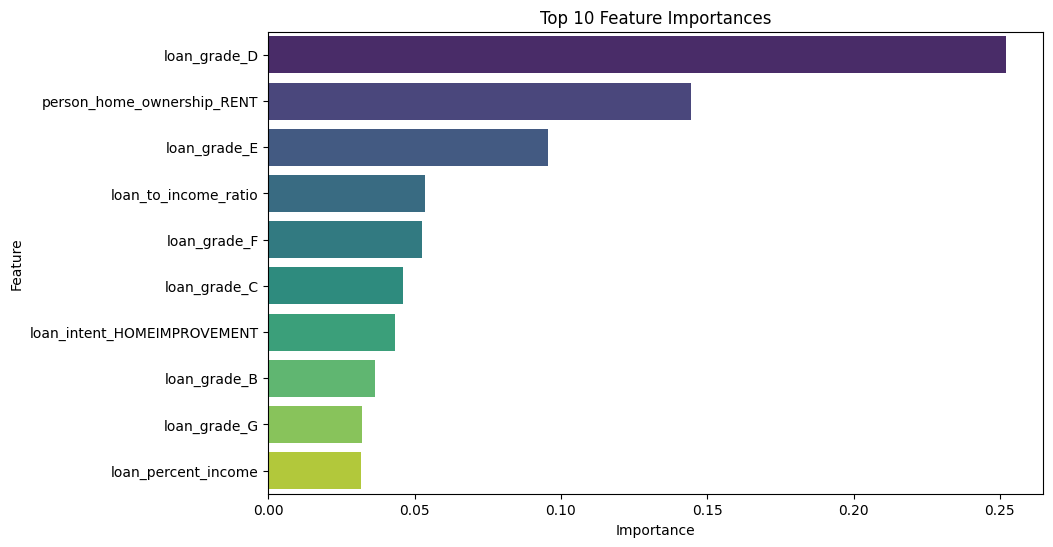

In [19]:
import numpy as np

# Get feature importances
importances = model.feature_importances_
features = X.columns # Get feature names from our X DataFrame

# Create a DataFrame for easy viewing
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\n--- Top 10 Most Important Features ---")
print(importance_df.head(10))

# Plot the top 10 features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(10), palette='viridis')
plt.title('Top 10 Feature Importances')
plt.show()

**Result:**
The model was a success. The evaluation metrics provided a clear picture of its strengths:
1. Overall Accuracy: 93%. The model was correct in its prediction 93% of the time.
2. Precision (for "Will Default"): 94%. When the model predicted a default, it was correct 94% of the time. This shows it doesn't create many "false positives."
3. Recall (for "Will Default"): 73%. This is the key risk metric. The model successfully identified and "caught" 73% of all actual defaulters in the test set.
4. Key Insights (Feature Importance): The model's logic was rational and powerful.
    1. The #1 predictor was loan_grade_D, showing the model correctly identified high-risk loan grades.
    2. The #2 predictor was person_home_ownership_RENT, a classic risk factor.
    3. Our engineered feature, loan_to_income_ratio, was the #4 most important feature, proving that our work on Day 3 added significant value to the model.
